In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import utils 
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=10000, suppress=True)
classifiers_q2 = {
    'CART': DecisionTreeClassifier(random_state=1),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'MLP (40-20)': MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
}
mlp_base_params = {'hidden_layer_sizes': (40, 20), 'max_iter': 1000, 'random_state': 1}

# Question 1: Chargement des données et préparation

In [3]:
df = pd.read_csv("./credit_scoring.csv", sep=';', engine='python')
print("Données 'credit_scoring.csv' chargées.")

X = df.values[:, :-1] 
Y = df.values[:, -1]

print(f"Taille de l'échantillon complet: {X.shape[0]} individus et {X.shape[1]} variables")

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=1
)

print(f"Séparation Train/Test (50/50). Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

Données 'credit_scoring.csv' chargées.
Taille de l'échantillon complet: 4375 individus et 13 variables
Séparation Train/Test (50/50). Train: 2187 | Test: 2188


# Question 2: Apprentissage et évaluation de modèles (sans prétraitement)


QUESTION 2: COMPARAISON AVEC DONNÉES BRUTES

--- Comparaison des classifieurs (Brut) ---
--- Résultats CART (Brut) ---
Matrice de confusion:
[[ 325  279]
 [ 318 1266]]
Accuracy: 0.7271 | Rappel: 0.7271 | Score final (Acc+Recall)/2: 0.7271


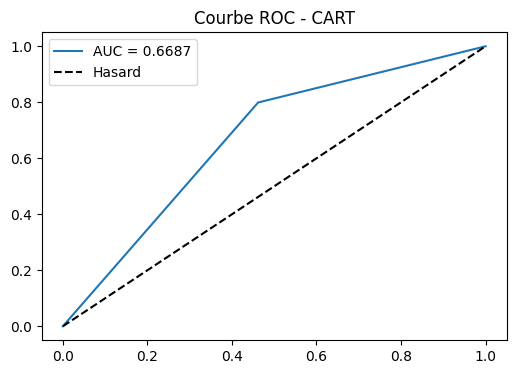

--- Résultats KNN (k=5) (Brut) ---
Matrice de confusion:
[[ 189  415]
 [ 187 1397]]
Accuracy: 0.7249 | Rappel: 0.7249 | Score final (Acc+Recall)/2: 0.7249


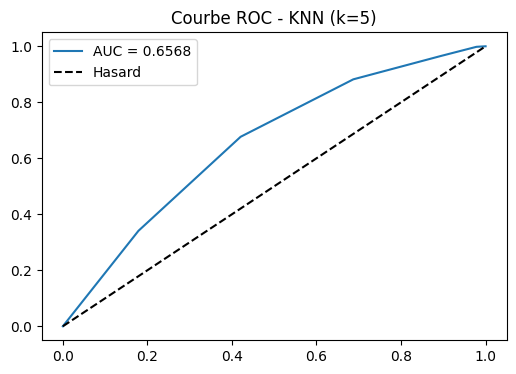

--- Résultats MLP (40-20) (Brut) ---
Matrice de confusion:
[[ 400  204]
 [ 517 1067]]
Accuracy: 0.6705 | Rappel: 0.6705 | Score final (Acc+Recall)/2: 0.6705


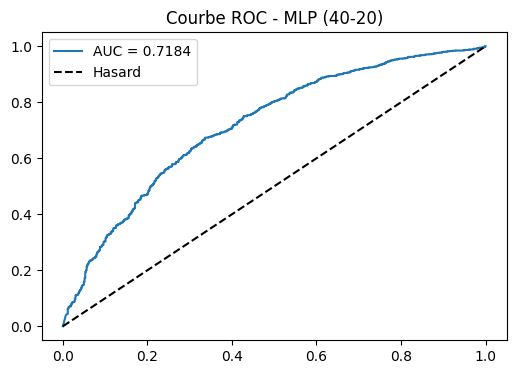


MEILLEUR: CART (Score final: 0.7271)


In [ ]:
print("\n" + "="*80)
print("QUESTION 2: COMPARAISON AVEC DONNÉES BRUTES")
print("="*80)
meilleur_nom_q2, meilleur_modele_q2 = utils.run_classifiers_train_test(
    classifiers_q2, X_train, Y_train, X_test, Y_test, mode='Brut'
)

# Question 3: Normalisation des variables continues

Données standardisées (StandardScaler).

QUESTION 3: COMPARAISON AVEC DONNÉES NORMALISÉES

--- Comparaison des classifieurs (Normalisé) ---
--- Résultats CART (Normalisé) ---
Matrice de confusion:
[[ 322  282]
 [ 315 1269]]
Accuracy: 0.7271 | Rappel: 0.7271 | Score final (Acc+Recall)/2: 0.7271


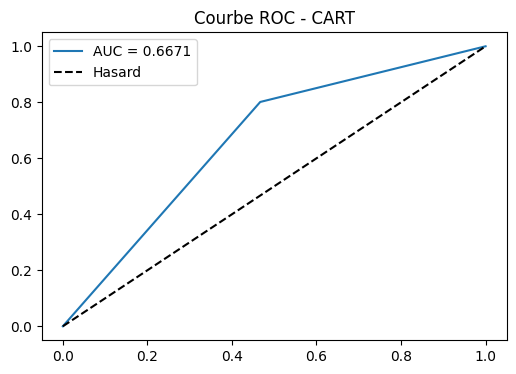

--- Résultats KNN (k=5) (Normalisé) ---
Matrice de confusion:
[[ 286  318]
 [ 223 1361]]
Accuracy: 0.7527 | Rappel: 0.7527 | Score final (Acc+Recall)/2: 0.7527


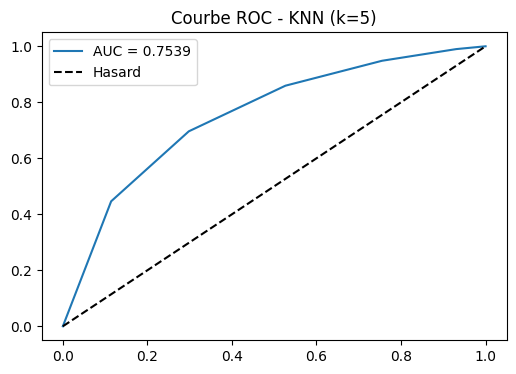

--- Résultats MLP (40-20) (Normalisé) ---
Matrice de confusion:
[[ 331  273]
 [ 286 1298]]
Accuracy: 0.7445 | Rappel: 0.7445 | Score final (Acc+Recall)/2: 0.7445


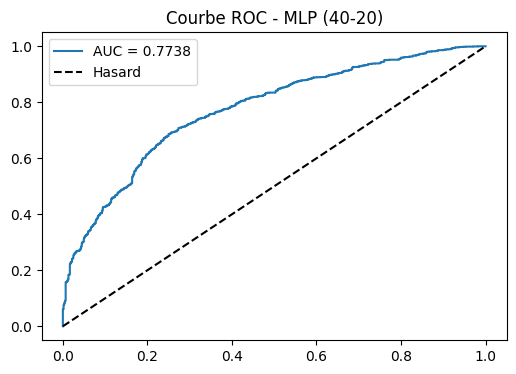


MEILLEUR: KNN (k=5) (Score final: 0.7527)


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Données standardisées (StandardScaler).")


print("\n" + "="*80)
print("QUESTION 3: COMPARAISON AVEC DONNÉES NORMALISÉES")
print("="*80)
meilleur_nom_q3, meilleur_modele_q3 = utils.run_classifiers_train_test(
    classifiers_q2, X_train_scaled, Y_train, X_test_scaled, Y_test, mode='Normalisé'
)

# Question 4: Création de nouvelles variables (ACP)

Dimensions après concaténation: (2187, 16)
Variance totale expliquée par les 3 PC: 44.14%

QUESTION 4: COMPARAISON AVEC DONNÉES NORMALISÉES + ACP

--- Comparaison des classifieurs (Normalisé + ACP) ---
--- Résultats CART (Normalisé + ACP) ---
Matrice de confusion:
[[ 335  269]
 [ 331 1253]]
Accuracy: 0.7258 | Rappel: 0.7258 | Score final (Acc+Recall)/2: 0.7258


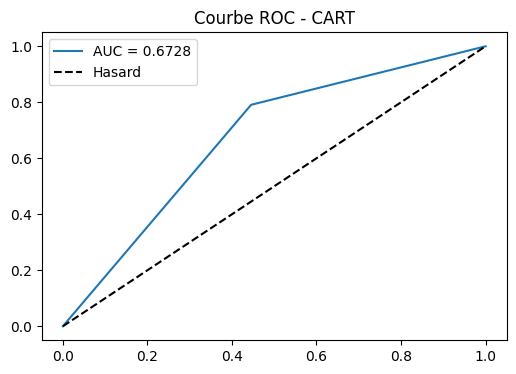

--- Résultats KNN (k=5) (Normalisé + ACP) ---
Matrice de confusion:
[[ 283  321]
 [ 212 1372]]
Accuracy: 0.7564 | Rappel: 0.7564 | Score final (Acc+Recall)/2: 0.7564


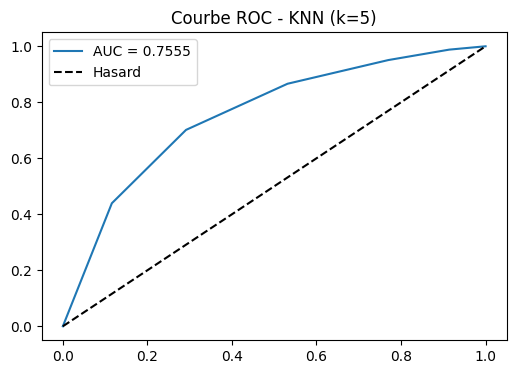

--- Résultats MLP (40-20) (Normalisé + ACP) ---
Matrice de confusion:
[[ 318  286]
 [ 261 1323]]
Accuracy: 0.7500 | Rappel: 0.7500 | Score final (Acc+Recall)/2: 0.7500


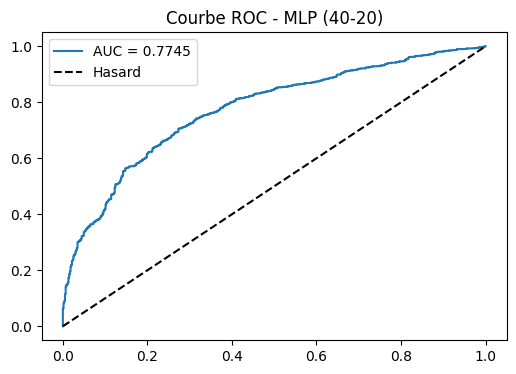


MEILLEUR: KNN (k=5) (Score final: 0.7564)


In [9]:
pca = PCA(n_components=3, random_state=1)
pca.fit(X_train_scaled)

X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


X_train_with_pca = np.concatenate([X_train_scaled, X_train_pca], axis=1)
X_test_with_pca = np.concatenate([X_test_scaled, X_test_pca], axis=1)

print(f"Dimensions après concaténation: {X_train_with_pca.shape}")
print(f"Variance totale expliquée par les 3 PC: {sum(pca.explained_variance_ratio_)*100:.2f}%")

print("\n" + "="*80)
print("QUESTION 4: COMPARAISON AVEC DONNÉES NORMALISÉES + ACP")
print("="*80)
meilleur_nom_q4, meilleur_modele_q4 = utils.run_classifiers_train_test(
    classifiers_q2, X_train_with_pca, Y_train, X_test_with_pca, Y_test, mode='Normalisé + ACP'
)


# Question 5: Sélection de variables (K Optimal)


Variables triées par importance :
['Income' 'Seniority' 'PC2' 'PC3' 'Price' 'PC1' 'Amount' 'Age' 'Records'
 'Assets' 'Expenses' 'Job' 'Time' 'Debt' 'Home' 'Marital']


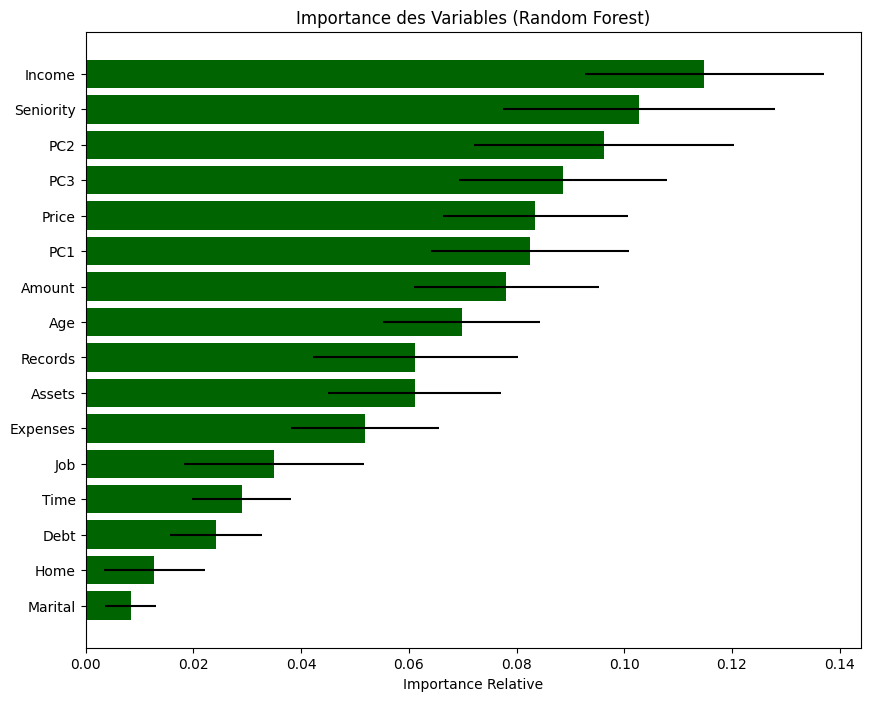


Détermination du bon nombre de variables (avec KNN (k=5))...
Meilleure Accuracy: 0.7358 (avec 16 variables)


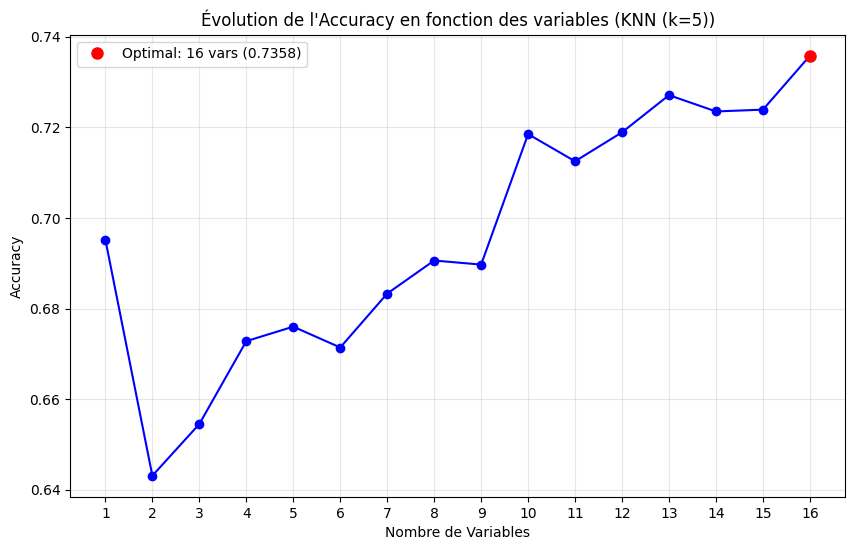

Le nombre optimal de variables à conserver est : 16


In [11]:
nom_cols_pca = list(df.columns[:-1]) + ['PC1', 'PC2', 'PC3']

# 1. Importance des variables (Q5 - Partie 1)
sorted_idx, feature_names = utils.importance_des_variables(X_train_with_pca, Y_train, nom_cols_pca)

# 2. Sélection du nombre optimal de variables (Q5 - Partie 2)
optimal_features_count = utils.selection_nombre_optimal_variables(
    X_train_with_pca, X_test_with_pca, Y_train, Y_test, sorted_idx, meilleur_nom_q4, mlp_base_params
)

best_k_indices = sorted_idx[:optimal_features_count] 
print(f"Le nombre optimal de variables à conserver est : {optimal_features_count}")

# Question 6: Paramétrage des classifieurs (Tuning du MLP)

In [13]:
X_train_selected_for_tuning = X_train_with_pca[:, best_k_indices]

base_mlp = MLPClassifier(random_state=1, max_iter=1000)
param_grid_mlp = {
    'hidden_layer_sizes': [(30, 15), (40, 20), (50, 25)], 
    'activation': ['tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01] 
}

tuned_mlp, best_mlp_params = utils.recherche_meilleurs_parametres(
    X_train_selected_for_tuning, Y_train, base_mlp, param_grid_mlp
)


🔄 Recherche des meilleurs hyperparamètres (GridSearchCV)...

Recherche fini en 153.62 secondes.
   Meilleurs paramètres: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 15)}


# Question 7 & 8: Création du Pipeline et Orchestration


################################################################################
ORCHESTRATION DU PIPELINE (Q1 à Q8) : Création du Pipeline Final
################################################################################

################################################################################
ORCHESTRATION DU PIPELINE (Q1 à Q8)
################################################################################

[Étape 1] Préparation des données: Normalisation + ACP...
[Étape 2] Sélection de variables (RF + MLP)...

Variables triées par importance :
['Income' 'Seniority' 'PC2' 'PC3' 'Price' 'PC1' 'Amount' 'Age' 'Records'
 'Assets' 'Expenses' 'Job' 'Time' 'Debt' 'Home' 'Marital']


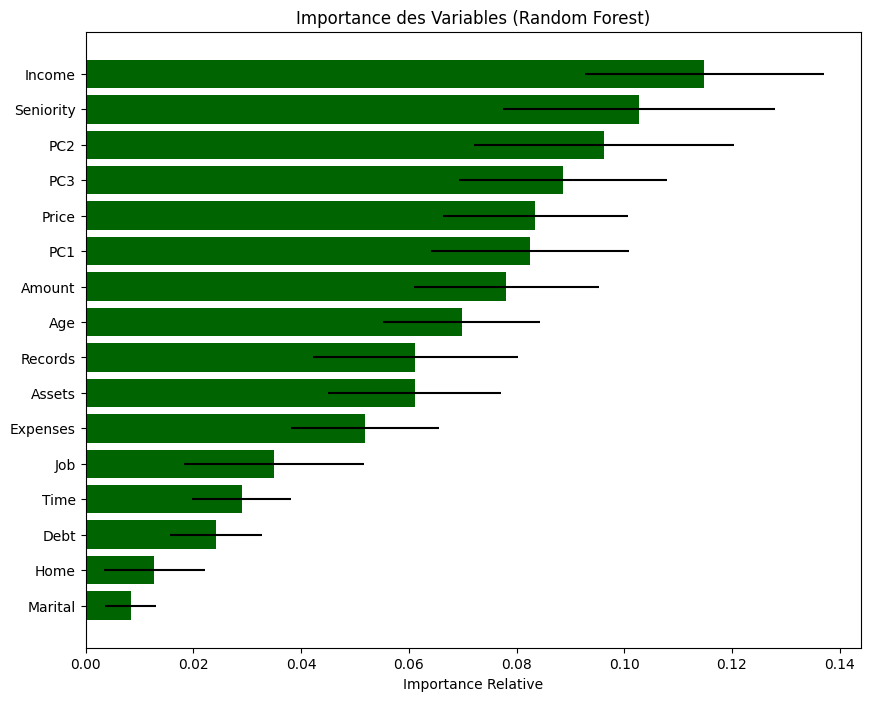


Détermination du bon nombre de variables (avec MLP)...
Meilleure Accuracy: 0.7660 (avec 10 variables)


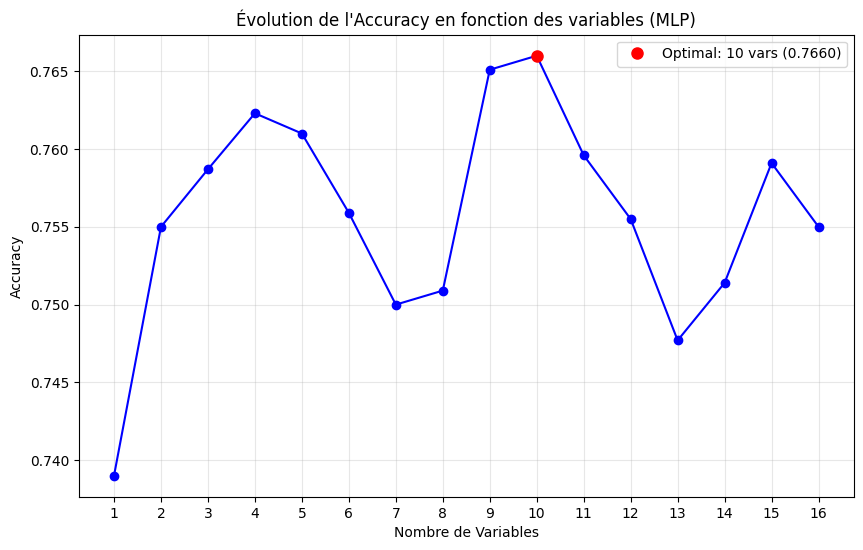

[Étape 3] Tuning du MLP (GridSearchCV)...

🔄 Recherche des meilleurs hyperparamètres (GridSearchCV)...

Recherche fini en 165.58 secondes.
   Meilleurs paramètres: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (30, 15)}
[Étape 4] Création et Entraînement du pipeline...

Création et Entraînement du pipeline vers credit_scoring_pipeline.pkl...
Pipeline créé, entraîné, et sauvegardé.

--- Validation Finale du Pipeline Orchestré ---
Accuracy: 0.7660
AUC: 0.8034

Pipeline de l'API (Q9) sauvegardé sous 'credit_scoring_pipeline.pkl'.


In [15]:
print("\n" + "#"*80)
print("ORCHESTRATION DU PIPELINE (Q1 à Q8) : Création du Pipeline Final")
print("#"*80)

final_pipeline_orchestre = utils.pipeline_generation_train_test_split(
    df, X_train, Y_train, X_test, Y_test
)

Y_pred_pipe = final_pipeline_orchestre.predict(X_test)
Y_proba_pipe = final_pipeline_orchestre.predict_proba(X_test)[:, 1]

print("\n--- Validation Finale du Pipeline Orchestré ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_pipe):.4f}")
print(f"AUC: {roc_auc_score(Y_test, Y_proba_pipe):.4f}")
print(f"\nPipeline de l'API (Q9) sauvegardé sous 'credit_scoring_pipeline.pkl'.")

# Question 10: Comparaison avec Validation Crosée (CV) et Orchestration Finale

In [17]:
X_data_q10 = df.iloc[:, :-1].values
Y_data_q10 = df.iloc[:, -1].values

best_clf_cv_name, best_ds_cv_name = utils.run_classifiers_cv(X_data_q10, Y_data_q10)

if best_clf_cv_name.startswith('Random Forest'):
    base_clf_q10 = RandomForestClassifier(random_state=1, n_estimators=200, n_jobs=-1)
    param_grid_q10 = {'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}
    
    X_train_full = X_data_q10[train_test_split(range(len(X_data_q10)), test_size=0.5, random_state=1)[0]]
    Y_train_full = Y_data_q10[train_test_split(range(len(Y_data_q10)), test_size=0.5, random_state=1)[0]]
    X_scaled_full = StandardScaler().fit_transform(X_train_full)
    X_pca_full = np.concatenate([X_scaled_full, PCA(n_components=3, random_state=1).fit_transform(X_scaled_full)], axis=1)
    
    tuned_final_clf, best_cv_params = utils.recherche_meilleurs_parametres(
        X_pca_full[:, best_k_indices], Y_train_full, base_clf_q10, param_grid_q10
    )
else:
    tuned_final_clf = tuned_mlp
    best_cv_params = best_mlp_params

# 3. Orchestration Finale CV (Entraînement sur TOUTES les données X_data_q10)
final_pipeline_cv_orchestre = utils.pipeline_generation_cv(
    df, X_data_q10, Y_data_q10, best_clf_cv_name, best_cv_params, optimal_features_count, X_test, Y_test
)

print("\nPartie I (Q1-Q10) complète. Le pipeline de production est sauvegardé sous 'final_production_pipeline_cv.pkl'.")



QUESTION 10: COMPARAISON ROBUSTE (10-FOLD CROSS-VALIDATION)

--- Jeu de Données: Original ---
  CART                 | ACC: 0.7269 +/- 0.0252 | AUC: 0.6556 +/- 0.0318 | SCORE_F: 0.7265 +/- 0.0245 | Time: 0.37s
  ID3 (Entropy)        | ACC: 0.7234 +/- 0.0244 | AUC: 0.6635 +/- 0.0295 | SCORE_F: 0.7259 +/- 0.0259 | Time: 0.30s
  Decision Stump       | ACC: 0.7221 +/- 0.0184 | AUC: 0.6181 +/- 0.0283 | SCORE_F: 0.6570 +/- 0.0423 | Time: 0.12s
  KNN (k=5)            | ACC: 0.7152 +/- 0.0170 | AUC: 0.6622 +/- 0.0271 | SCORE_F: 0.7020 +/- 0.0177 | Time: 0.29s
  MLP (20-10)          | ACC: 0.7097 +/- 0.0363 | AUC: 0.7280 +/- 0.0356 | SCORE_F: 0.7175 +/- 0.0217 | Time: 5.57s
  Bagging (200)        | ACC: 0.7819 +/- 0.0149 | AUC: 0.8234 +/- 0.0204 | SCORE_F: 0.7774 +/- 0.0152 | Time: 20.07s
  AdaBoost (200)       | ACC: 0.7959 +/- 0.0151 | AUC: 0.8325 +/- 0.0159 | SCORE_F: 0.7912 +/- 0.0161 | Time: 7.76s
  Random Forest (200)  | ACC: 0.7863 +/- 0.0148 | AUC: 0.8290 +/- 0.0179 | SCORE_F: 0.7809 +

# Partie II: Données Hétérogènes


[Chargement] Lecture du fichier 'credit.data'...
Fichier chargé avec succès. Dimensions : (688, 16)
Distribution de la cible : 
15
0    383
1    305
Name: count, dtype: int64

QUESTION II.1: COMPARAISON SUR DONNÉES NUMÉRIQUES (Brut vs Normalisé)

################################################################################
PARTIE II - QUESTION 1: DONNÉES NUMÉRIQUES SEULES
################################################################################
Taille après nettoyage: 666 individus (6 variables)

--- Comparaison des classifieurs (II.1 Brut) ---
--- Résultats CART (II.1 Brut) ---
Matrice de confusion:
[[132  56]
 [ 46  99]]
Accuracy: 0.6937 | Rappel: 0.6937 | Score final (Acc+Recall)/2: 0.6937


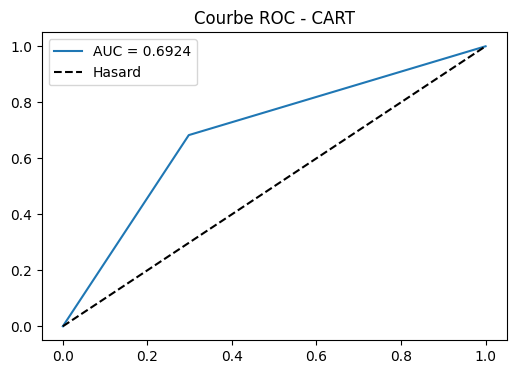

--- Résultats KNN (k=5) (II.1 Brut) ---
Matrice de confusion:
[[154  34]
 [ 63  82]]
Accuracy: 0.7087 | Rappel: 0.7087 | Score final (Acc+Recall)/2: 0.7087


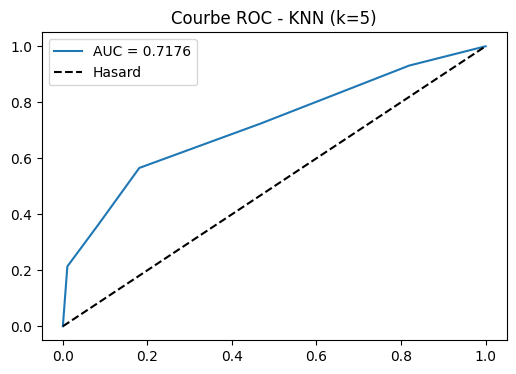


MEILLEUR: KNN (k=5) (Score final: 0.7087)

--- Comparaison des classifieurs (II.1 Normalisé) ---
--- Résultats CART (II.1 Normalisé) ---
Matrice de confusion:
[[132  56]
 [ 46  99]]
Accuracy: 0.6937 | Rappel: 0.6937 | Score final (Acc+Recall)/2: 0.6937


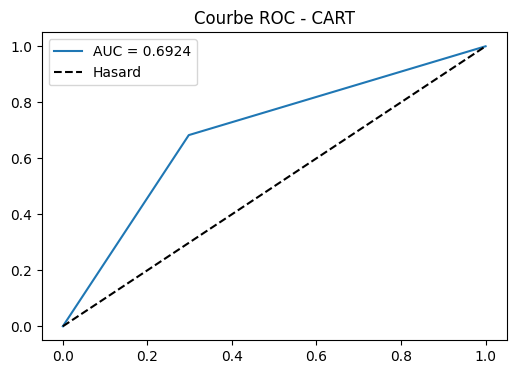

--- Résultats KNN (k=5) (II.1 Normalisé) ---
Matrice de confusion:
[[158  30]
 [ 54  91]]
Accuracy: 0.7477 | Rappel: 0.7477 | Score final (Acc+Recall)/2: 0.7477


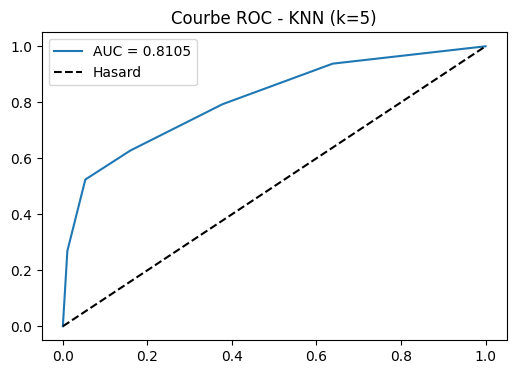


MEILLEUR: KNN (k=5) (Score final: 0.7477)

QUESTION II.2: COMPARAISON SUR DONNÉES HÉTÉROGÈNES (Imputation + OHE)

################################################################################
PARTIE II - QUESTION 2: DONNÉES HÉTÉROGÈNES ET MANQUANTES
################################################################################
Dimensions finales (Entraînement): (344, 46)

--- Comparaison des classifieurs (II.2 Final) ---
--- Résultats CART (II.2 Final) ---
Matrice de confusion:
[[165  35]
 [ 25 119]]
Accuracy: 0.8256 | Rappel: 0.8256 | Score final (Acc+Recall)/2: 0.8256


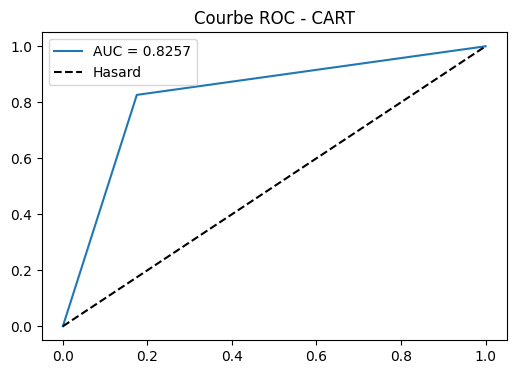

--- Résultats MLP (20-10) (II.2 Final) ---
Matrice de confusion:
[[166  34]
 [ 22 122]]
Accuracy: 0.8372 | Rappel: 0.8372 | Score final (Acc+Recall)/2: 0.8372


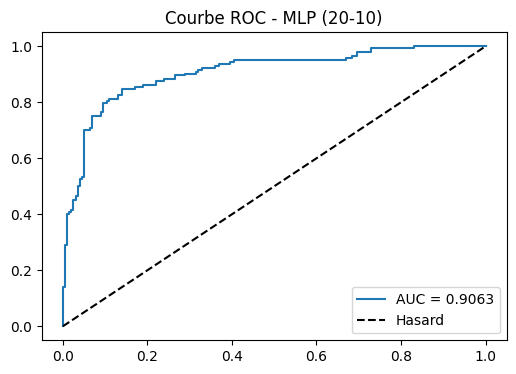


MEILLEUR: MLP (20-10) (Score final: 0.8372)


In [19]:
col_num = [1, 2, 7, 10, 13, 14]
col_cat = [0, 3, 4, 5, 6, 8, 9, 11, 12]

try:
    print("\n[Chargement] Lecture du fichier 'credit.data'...")
    df_credit_data = pd.read_csv("./credit.data", header=None, na_values='?', sep='\t')

    target_col = df_credit_data.columns[-1]
    df_credit_data[target_col] = df_credit_data[target_col].map({'+': 1, '-': 0})

    print(f"Fichier chargé avec succès. Dimensions : {df_credit_data.shape}")
    print(f"Distribution de la cible : \n{df_credit_data[target_col].value_counts()}")

except FileNotFoundError:
    print("\nFichier 'credit.data' non trouvé. Simulation impossible avec credit_scoring.csv (structure différente).")
    # On crée un df vide pour éviter que ça plnate
    df_credit_data = pd.DataFrame()

if not df_credit_data.empty:

    ## Question II.1: Données numériques seules

    print("\n" + "="*80)
    print("QUESTION II.1: COMPARAISON SUR DONNÉES NUMÉRIQUES (Brut vs Normalisé)")
    print("="*80)

    # on passe le df et la liste des indices numériques
    X_train_num, X_test_num, Y_train_num, Y_test_num = utils.traitement_donnees_numeriques(df_credit_data, col_num)

    classifiers_ii_1 = {'CART': DecisionTreeClassifier(random_state=1), 'KNN (k=5)': KNeighborsClassifier(n_neighbors=5)}
    utils.run_classifiers_train_test(classifiers_ii_1, X_train_num, Y_train_num, X_test_num, Y_test_num, mode='II.1 Brut')

    scaler_ii = StandardScaler()
    X_train_num_scaled = scaler_ii.fit_transform(X_train_num)
    X_test_num_scaled = scaler_ii.transform(X_test_num)

    utils.run_classifiers_train_test(classifiers_ii_1, X_train_num_scaled, Y_train_num, X_test_num_scaled, Y_test_num, mode='II.1 Normalisé')

    ## Question II.2: Données hétérogènes complètes (avec imputation)

    print("\n" + "="*80)
    print("QUESTION II.2: COMPARAISON SUR DONNÉES HÉTÉROGÈNES (Imputation + OHE)")
    print("="*80)

    X_full_ii = df_credit_data.values[:, :-1]
    Y_full_ii = df_credit_data.values[:, -1].astype(int)

    X_train_final_ii, X_test_final_ii, Y_train_comb_ii, Y_test_comb_ii = utils.traitement_donnees_heterogenes_imputation(
        X_full_ii, Y_full_ii, col_num, col_cat
    )

    classifiers_ii_2 = {
        'CART': DecisionTreeClassifier(random_state=1),
        'MLP (20-10)': MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1, max_iter=500)
    }

    utils.run_classifiers_train_test(
        classifiers_ii_2,
        X_train_final_ii, Y_train_comb_ii, X_test_final_ii, Y_test_comb_ii,
        mode='II.2 Final'
    )

else:
    print("Erreur : Peut pas exécuter la Partie II sans les données.")